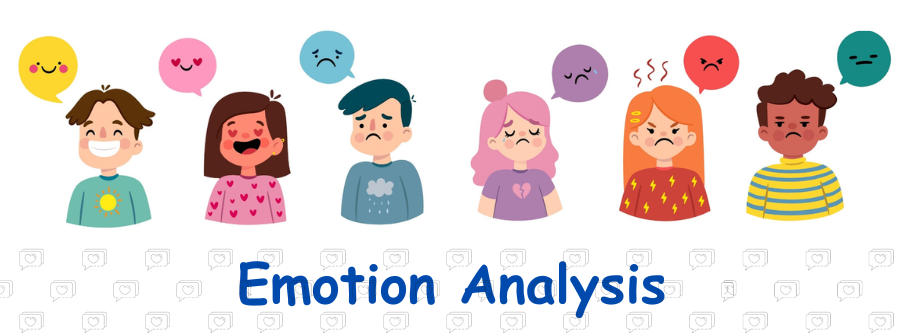

## Setting the Environment

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!pip install textblob
!pip install neattext
!pip install contractions
!pip install transformers

## Import Libraries

In [68]:
import nltk
import numpy as np
import contractions
import pandas as pd
import seaborn as sns
import neattext as nt
nltk.download('punkt')
import tensorflow as tf
nltk.download("wordnet")
from textblob import TextBlob
from collections import Counter
from sklearn import preprocessing
from keras.regularizers import l2
from keras.utils import pad_sequences
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.layers import LSTM, Flatten, BatchNormalization,Activation
from tensorflow.keras.layers import Dense, Dropout,InputLayer,Bidirectional, GRU
from tensorflow.keras.layers import Embedding, GlobalMaxPooling1D, Dense,Conv1D,MaxPooling1D

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [69]:
#Load dataset
data=pd.read_csv("/content/drive/MyDrive/Colab_Datasets/emotion_dataset.csv")
data.head()

,Emotion,Text
0,neutral,Why ?
1,joy,Sage Act upgrade on my to do list for tommorow.
2,sadness,ON THE WAY TO MY HOMEGIRL BABY FUNERAL!!! MAN ...
3,joy,Such an eye ! The true hazel eye-and so brill...
4,joy,@Iluvmiasantos ugh babe.. hugggzzz for u .! b...


In [70]:
#Renaming the column name
data.rename(columns={"Emotion": "emotion"}, inplace=True)
data.rename(columns={"Text": "content"}, inplace=True)

In [71]:
data.shape

(34792, 2)

In [72]:
data.isnull().sum()

emotion    0
content    0
dtype: int64

In [73]:
#Removing the empty string from “emotion” and eliminating zeros from the “content” .
data = data[data["emotion"].str.contains("empty") == False]
data = data[data["content"].str.contains("0") == False]

In [74]:
data.head()

,emotion,content
0,neutral,Why ?
1,joy,Sage Act upgrade on my to do list for tommorow.
2,sadness,ON THE WAY TO MY HOMEGIRL BABY FUNERAL!!! MAN ...
3,joy,Such an eye ! The true hazel eye-and so brill...
4,joy,@Iluvmiasantos ugh babe.. hugggzzz for u .! b...


In [75]:
(data['content']==0).sum()

0

In [76]:
data['emotion'].unique()

array(['neutral', 'joy', 'sadness', 'fear', 'surprise', 'anger', 'shame',
       'disgust'], dtype=object)

[Text(0, 0, 'neutral'),
 Text(1, 0, 'joy'),
 Text(2, 0, 'sadness'),
 Text(3, 0, 'fear'),
 Text(4, 0, 'surprise'),
 Text(5, 0, 'anger'),
 Text(6, 0, 'shame'),
 Text(7, 0, 'disgust')]

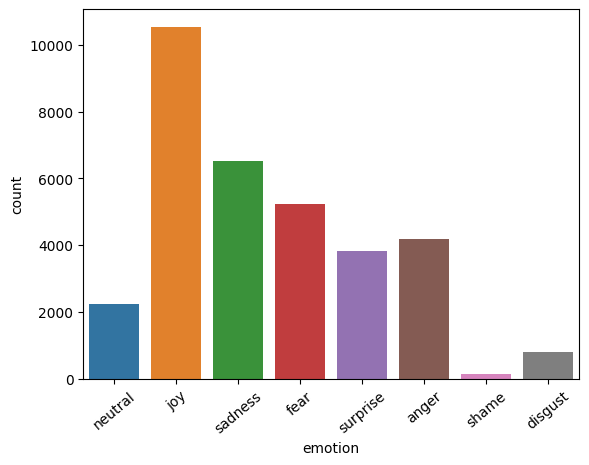

In [77]:
emotions_count=sns.countplot(x='emotion',data=data)
emotions_count.set_xticklabels(emotions_count.get_xticklabels(), rotation=40)

## Text Processing

In [78]:
data.head()

,emotion,content
0,neutral,Why ?
1,joy,Sage Act upgrade on my to do list for tommorow.
2,sadness,ON THE WAY TO MY HOMEGIRL BABY FUNERAL!!! MAN ...
3,joy,Such an eye ! The true hazel eye-and so brill...
4,joy,@Iluvmiasantos ugh babe.. hugggzzz for u .! b...


**Lowercasing-**  Convert all text to lowercase. This ensures uniformity and helps in reducing the dimensionality of the data.

In [79]:
data['content']=data['content'].str.lower()
data.head()

,emotion,content
0,neutral,why ?
1,joy,sage act upgrade on my to do list for tommorow.
2,sadness,on the way to my homegirl baby funeral!!! man ...
3,joy,such an eye ! the true hazel eye-and so brill...
4,joy,@iluvmiasantos ugh babe.. hugggzzz for u .! b...


**Handling HTML Tags, emojis, emails and URLs-** If dealing with web data then remove HTML tags, URLS, emojis, emails.

In [80]:
data['content'] = data['content'].apply(lambda text: nt.remove_html_tags(text))
data['content']= data['content'].apply(lambda text: nt.remove_urls(text))
data['content']= data['content'].apply(lambda text: nt.remove_emojis(text))
data['content']= data['content'].apply(lambda text: nt.remove_emails(text))


**Removing Special Characters and Numbers-** Remove any non-alphabetic characters and numbers. These often do not contribute to the semantics of the text.

In [81]:
# Use regular expression to remove non-alphabetic characters and numbers
# def remove_special_chars_and_numbers(text):
#     cleaned_text = re.sub(r'[^a-zA-Z\s]', '', text)
#     return cleaned_text
# data['content']=[remove_special_chars_and_numbers(text) for text in data['content']]
# data.head()

data['content']= data['content'].apply(lambda text: nt.remove_special_characters(text))
data['content']= data['content'].apply(lambda text: nt.remove_numbers(text))



**Handling Contractions-** Expand contractions (e.g., "can't" to "cannot")

In [82]:
# vaex_data['content']= vaex_data['content'].apply(lambda text: nt.fix_contractions(text))
data['content']= data['content'].apply(lambda text:  contractions.fix(text))



**Removing Punctuation-** Remove all punctuation marks (e.g., periods, commas, exclamation marks) as they generally do not carry much information for many NLP tasks.



In [83]:
# Using regular expression to remove punctuation
# def remove_punctuation(text):
#     cleaned_text = re.sub(r'[^\w\s]', '', text)
#     return cleaned_text
# data['content']=[remove_punctuation(text) for text in data['content']]
# data.head()

#Using NeatText
data['content']= data['content'].apply(lambda text: nt.remove_punctuations(text))

**Removing Stopwords-**  Remove common, low-information words (e.g., "and", "the", "in") known as stopwords.

In [84]:
data['content']= data['content'].apply(lambda text: nt.remove_stopwords(text))

**Removing Stopwords-**  Remove common, low-information words (e.g., "and", "the", "in") known as stopwords.

In [85]:
data['content']= data['content'].apply(lambda text: nt.remove_stopwords(text))


**Tokenization-** Split the text into individual words or tokens. This makes it easier to analyze and process.

In [86]:
data['content']= data['content'].apply(lambda text: word_tokenize(text))


**Lemmatization-** Reduce words to their base or root form. This helps in reducing the dimensionality of the feature space.

In [87]:
lemmatizer = WordNetLemmatizer()
data['content'] = data['content'].apply(lambda text: [lemmatizer.lemmatize(word,pos='v') for word in text])

Label encoding is a technique used to convert categorical data, specifically labels or classes, into numerical values.

In [61]:
label_encoder = preprocessing.LabelEncoder()

data['emotion']= label_encoder.fit_transform(data['emotion'])

data['emotion'].unique()

array([4, 3, 5, 2, 7, 0, 6, 1])

For mapping of the pretrained model

In [88]:
import pandas as pd
from sklearn import preprocessing

# Label encode the 'emotion' column
label_encoder = preprocessing.LabelEncoder()
data['emotion_number'] = label_encoder.fit_transform(data['emotion'])

# Create a DataFrame with the required columns
result_df = pd.DataFrame({
    'content': data['content'],
    'emotion_text': data['emotion'],
    'emotion_number': data['emotion_number']
})


                                             content emotion_text  \
0                                                 []      neutral   
1               [sage, act, upgrade, list, tommorow]          joy   
2  [way, homegirl, baby, funeral, man, hate, fune...      sadness   
3  [eye, true, hazel, eyeand, brilliant, regular,...          joy   
4  [iluvmiasantos, ugh, babe, hugggzzz, babe, naa...          joy   
5  [expect, extremely, important, phonecall, minu...         fear   
6  [wait, live, miss, nh, painful, enuf, suraj, p...      sadness   
7  [maken, tip, stop, op, een, moment, dat, je, h...     surprise   
8  [en, dan, krijg, je, ff, een, cadeautje, van, ...     surprise   
9  [drummer, boy, bij, op, verzoek, van, biemoost...     surprise   

   emotion_number  
0               4  
1               3  
2               5  
3               3  
4               3  
5               2  
6               5  
7               7  
8               7  
9               7  


In [89]:
result_df=result_df.to_csv("/content/drive/MyDrive/Colab_Datasets/result_df.csv")
result_df

,content,emotion_text,emotion_number
0,[],neutral,4
1,"[sage, act, upgrade, list, tommorow]",joy,3
2,"[way, homegirl, baby, funeral, man, hate, fune...",sadness,5
3,"[eye, true, hazel, eyeand, brilliant, regular,...",joy,3
4,"[iluvmiasantos, ugh, babe, hugggzzz, babe, naa...",joy,3
...,...,...,...
34787,"[michelgw, gift, hope, like, hand, wear, warm,...",surprise,7
34788,"[world, meso, world, definitely, cnt, away]",joy,3
34789,"[man, rob, today]",anger,0
34790,"[youu, jealousy, lose]",fear,2


In [63]:
clean_text=data.to_csv("/content/drive/MyDrive/Colab_Datasets/clean_text.csv")

In [64]:
clean_text=pd.read_csv("/content/drive/MyDrive/Colab_Datasets/clean_text.csv")


In [65]:
clean_text=clean_text.sample(n=10000, random_state=1)

In [66]:
clean_text['emotion'].value_counts()

3    3157
5    1899
2    1522
0    1231
7    1188
4     724
1     235
6      44
Name: emotion, dtype: int64

In [67]:
clean_text.head()

,Unnamed: 0,emotion,content
16391,17041,3,"['realize', 'night', 'realize', 'right', 'bed'..."
13161,13688,3,"['share', 'hotel', 'room', 'snore', 'parent']"
13465,14004,3,"['greatest', 'joiy', 'succeded', 'acquire', 'm..."
18972,19710,3,"['soo', 'jus', 'tryna', 'feel', 'sum']"
28611,29717,3,"['wake', 'sound', 'deeds', 'laugh', 'room', 'p..."


## Data Spliting
Splitting the data into training, validation, and testing sets.



The training set is the portion of the data used to train model.

The validation set is used during the training process to evaluate the model's performance and fine-tune hyperparameters. It helps in preventing overfitting. The validation set is not used for training.

The testing set is used after the model is trained to provide an unbiased evaluation of the final model's performance.

In [ ]:
X = data['content']
y = data['emotion']

# Split the data into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)  # 70% training, 30% temp

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, shuffle=True)  # 15% validation, 15% testing


In [ ]:
X_train.shape,y_train.shape,X_test.shape,y_test.shape,X_val.shape,y_val.shape

((23448,), (23448,), (5025,), (5025,), (5025,), (5025,))

Checking the distribution of the data with respect to emotion

In [ ]:
print("-----y train-----\n",y_train.value_counts())
print("-----y test-----\n",y_test.value_counts())

-----y train-----
 3    7301
5    4575
2    3701
0    2977
7    2662
4    1544
1     571
6     117
Name: emotion, dtype: int64
-----y test-----
 3    1600
5    1011
2     763
0     616
7     566
4     318
1     136
6      15
Name: emotion, dtype: int64


## Preparing embedding layer

###Tokenization
Tokenization is the process of converting text into a sequence of numerical values, where each unique word is assigned a unique integer index.

In [ ]:
word_tokenizer= Tokenizer()
word_tokenizer.fit_on_texts(X_train)
X_train= word_tokenizer.texts_to_sequences(X_train)
X_test= word_tokenizer.texts_to_sequences(X_test)
X_val= word_tokenizer.texts_to_sequences(X_val)

The input_dim parameter should be the size of your vocabulary, i.e. the set of all unique words present.

In [ ]:
vocab_length= len(word_tokenizer.word_index)+1
vocab_length

26904

 ### Padding
 It ensures that the sequences of integers representing the text data have a consistent length.


In [ ]:
maxlen= 50 #Padding to fixed length 50
X_train=pad_sequences(X_train, padding='post',maxlen=maxlen)
X_test=pad_sequences(X_test, padding='post',maxlen=maxlen)
X_val=pad_sequences(X_val, padding='post',maxlen=maxlen)

### Word Embedding

Word embedding is a way to represent words as vectors (arrays of numbers) in such a way that the meaning of words is captured based on their context and relationships with other words.

Here’s how we can create word embeddings using pre-trained embeddings

In [ ]:
# Load GloVe (Global Vectors for Word Representation) word embeddings and create an Embeddings Dictionary

from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('/content/drive/MyDrive/Colab_Datasets/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [ ]:
# Create Embedding Matrix having 100 columns
# Containing 100-dimensional GloVe word embeddings for all words in our corpus.

embedding_matrix = zeros((vocab_length, 100))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [ ]:
embedding_matrix.shape

(26904, 100)

## Model

### Convolutional Neural Network

In [ ]:
# Define the model
cnn_model = Sequential()

# Embedding Layer:
cnn_model.add(Embedding(input_dim=vocab_length, output_dim=100,weights=[embedding_matrix], input_length=maxlen))

# Convolutional Layers:
cnn_model.add(Conv1D(filters=128, kernel_size=5, activation='prelu'))
cnn_model.add(GlobalMaxPooling1D())

# Dense Layers:
cnn_model.add(Dense(64, kernel_regularizer=l2(0.01)))
cnn_model.add(BatchNormalization())
cnn_model.add(Activation('prelu'))
cnn_model.add(Dropout(0.1)) # Adding Dropout with 10%

# Output Layer:
cnn_model.add(Dense(8, activation='softmax')) #8 emotions


In [ ]:
# Compile the model:
from keras.optimizers import SGD
opt = SGD(learning_rate = 0.001)
cnn_model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(cnn_model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 50, 100)           2690400   
                                                                 
 conv1d_4 (Conv1D)           (None, 46, 128)           64128     
                                                                 
 max_pooling1d (MaxPooling1  (None, 23, 128)           0         
 D)                                                              
                                                                 
 conv1d_5 (Conv1D)           (None, 21, 64)            24640     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 10, 64)            0         
 g1D)                                                            
                                                                 
 global_max_pooling1d_2 (Gl  (None, 64)               

In [ ]:
# Model training
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

cnn_model_history = cnn_model.fit(X_train, y_train, batch_size=128, epochs=100, verbose=1,validation_data=(X_val, y_val),callbacks=[early_stop])


Epoch 1/100
184/184 [==============================] - 22s 105ms/step - loss: 4.0754 - accuracy: 0.1807 - val_loss: 3.6368 - val_accuracy: 0.2794
Epoch 2/100
184/184 [==============================] - 18s 97ms/step - loss: 3.8036 - accuracy: 0.2062 - val_loss: 3.5178 - val_accuracy: 0.3288
Epoch 3/100
184/184 [==============================] - 19s 105ms/step - loss: 3.6562 - accuracy: 0.2421 - val_loss: 3.4207 - val_accuracy: 0.3574
Epoch 4/100
184/184 [==============================] - 20s 108ms/step - loss: 3.5710 - accuracy: 0.2686 - val_loss: 3.3537 - val_accuracy: 0.3773
Epoch 5/100
184/184 [==============================] - 18s 98ms/step - loss: 3.5039 - accuracy: 0.2960 - val_loss: 3.3104 - val_accuracy: 0.3855
Epoch 6/100
184/184 [==============================] - 18s 98ms/step - loss: 3.4608 - accuracy: 0.3040 - val_loss: 3.2737 - val_accuracy: 0.3946
Epoch 7/100
184/184 [==============================] - 17s 94ms/step - loss: 3.4151 - accuracy: 0.3184 - val_loss: 3.2419 - val

In [ ]:
# Predictions on the Test Set

score=cnn_model.evaluate(X_test,y_test)

158/158 [==============================] - 1s 5ms/step - loss: 1.7682 - accuracy: 0.5150


In [ ]:
# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 1.768208622932434
Test Accuracy: 0.5150249004364014


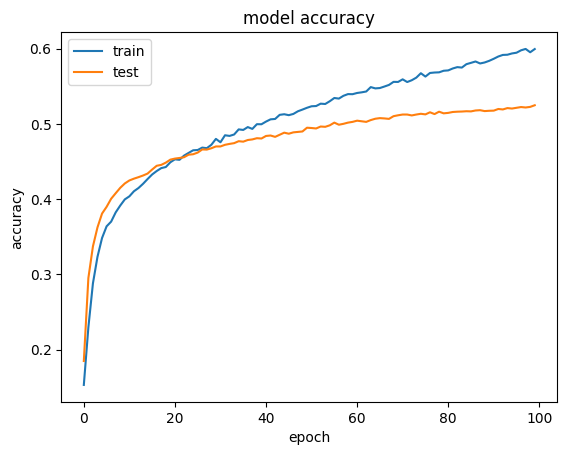

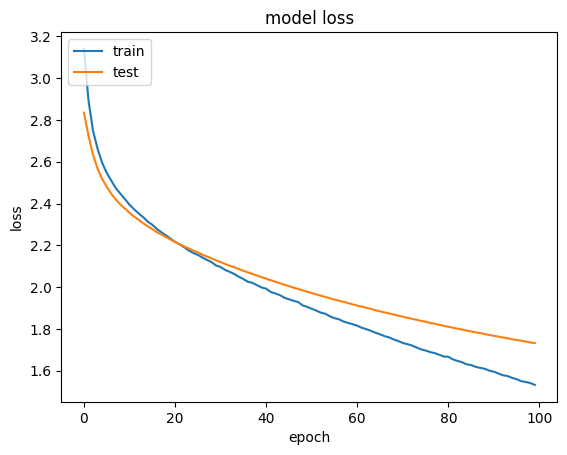

In [ ]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(cnn_model_history.history['accuracy'])
plt.plot(cnn_model_history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(cnn_model_history.history['loss'])
plt.plot(cnn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

In [ ]:
#Lets predict on validation data
Y_result= cnn_model.predict(X_val)
print(Y_result)

158/158 [==============================] - 1s 5ms/step
[[0.02373666 0.00129753 0.01021915 ... 0.04642559 0.00106131 0.03697697]
 [0.6121212  0.00368901 0.2739194  ... 0.04544926 0.00412445 0.01429707]
 [0.01761198 0.02437629 0.27937692 ... 0.05701572 0.00674887 0.217167  ]
 ...
 [0.11829383 0.00341037 0.05849488 ... 0.04019382 0.0049436  0.00910103]
 [0.10356033 0.01107334 0.11551193 ... 0.23135263 0.01427363 0.09811582]
 [0.0329786  0.00202541 0.01253387 ... 0.10081702 0.00181853 0.01744652]]


In [ ]:
import numpy as np

# Get the predicted class labels based on the highest probability
predicted_labels = np.argmax(Y_result, axis=1)

# You can inverse transform the predicted labels to get the original class names
predicted_emotions = label_encoder.inverse_transform(predicted_labels)

# Create a DataFrame to display the predicted labels
predictions_df = pd.DataFrame({'Predicted_Label': predicted_labels, 'Predicted_Emotion': predicted_emotions})

# Print the DataFrame
print(predictions_df)


      Predicted_Label Predicted_Emotion
0                   3               joy
1                   0             anger
2                   3               joy
3                   3               joy
4                   2              fear
...               ...               ...
5020                4           neutral
5021                3               joy
5022                4           neutral
5023                3               joy
5024                4           neutral

[5025 rows x 2 columns]


### LSTM

In [ ]:
from keras.layers import LSTM
# Neural Network architecture

lstm_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen)

lstm_model.add(embedding_layer)
lstm_model.add(BatchNormalization())
lstm_model.add(Dropout(0.3))
lstm_model.add(LSTM(128, return_sequences=True))
lstm_model.add(Bidirectional(LSTM(128, return_sequences=True)))
lstm_model.add(Bidirectional(LSTM(128)))

lstm_model.add(Dense(8, activation='softmax'))


In [ ]:
# Model compiling
opt = tf.keras.optimizers.Nadam(learning_rate=0.001)
lstm_model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['acc'])
print(lstm_model.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 50, 100)           2690400   
                                                                 
 batch_normalization_5 (Bat  (None, 50, 100)           400       
 chNormalization)                                                
                                                                 
 dropout_6 (Dropout)         (None, 50, 100)           0         
                                                                 
 lstm_4 (LSTM)               (None, 50, 128)           117248    
                                                                 
 bidirectional_2 (Bidirecti  (None, 50, 256)           263168    
 onal)                                                           
                                                                 
 bidirectional_3 (Bidirecti  (None, 256)              

In [ ]:
# Model training
early_stop = EarlyStopping(monitor='val_loss', patience=8 , restore_best_weights=True)

lstm_model_history = lstm_model.fit(X_train, y_train, batch_size=128, epochs=100, verbose=1,validation_data=(X_val, y_val),callbacks=[early_stop])

Epoch 1/100
184/184 [==============================] - 234s 1s/step - loss: 1.4092 - acc: 0.4804 - val_loss: 1.2627 - val_acc: 0.5425
Epoch 2/100
184/184 [==============================] - 214s 1s/step - loss: 1.1455 - acc: 0.5888 - val_loss: 1.1129 - val_acc: 0.6030
Epoch 3/100
184/184 [==============================] - 214s 1s/step - loss: 0.9726 - acc: 0.6584 - val_loss: 1.0673 - val_acc: 0.6235
Epoch 4/100
184/184 [==============================] - 207s 1s/step - loss: 0.7900 - acc: 0.7288 - val_loss: 1.0374 - val_acc: 0.6386
Epoch 5/100
184/184 [==============================] - 207s 1s/step - loss: 0.6529 - acc: 0.7778 - val_loss: 1.0640 - val_acc: 0.6352
Epoch 6/100
184/184 [==============================] - 203s 1s/step - loss: 0.5730 - acc: 0.8049 - val_loss: 1.1087 - val_acc: 0.6350
Epoch 7/100
184/184 [==============================] - 212s 1s/step - loss: 0.5153 - acc: 0.8229 - val_loss: 1.1246 - val_acc: 0.6281
Epoch 8/100
184/184 [==============================] - 208s 1s

In [ ]:
# Predictions on the Test Set

score=lstm_model.evaluate(X_test,y_test)

158/158 [==============================] - 21s 136ms/step - loss: 1.0634 - acc: 0.6358


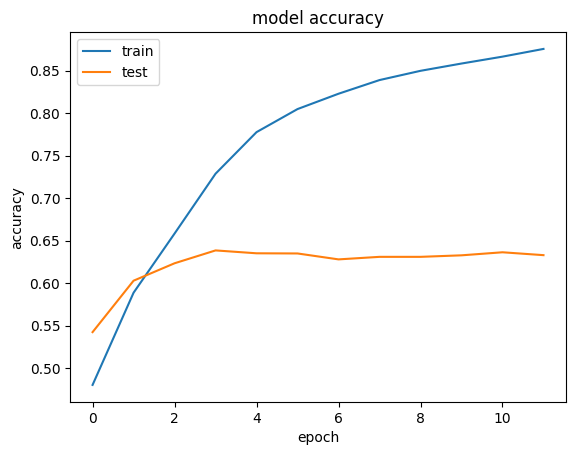

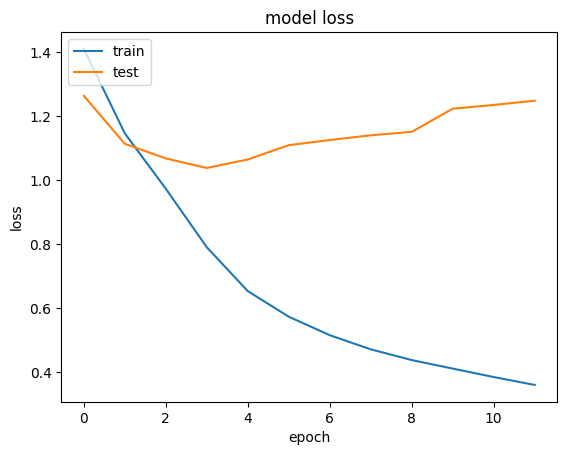

In [ ]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(lstm_model_history.history['acc'])
plt.plot(lstm_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(lstm_model_history.history['loss'])
plt.plot(lstm_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

### Roberta Pretrained Model

In [ ]:
data=pd.read_csv("/content/result_df.csv")

In [ ]:
data = data.sample(n=1000, random_state=1)

In [ ]:
from transformers import RobertaTokenizerFast, TFRobertaForSequenceClassification

roberta_tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base')


In [ ]:
X = data['content']
y = data['emotion_number']


In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)  # 70% training, 30% test

In [ ]:
train_encoding = roberta_tokenizer(X_train.to_list(), truncation=True, padding=True)
test_encoding = roberta_tokenizer(X_test.to_list(), truncation=True, padding=True)

train_encoding[0]


Encoding(num_tokens=91, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encoding),y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encoding),y_test))

train_dataset


<_TensorSliceDataset element_spec=({'input_ids': TensorSpec(shape=(91,), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(91,), dtype=tf.int32, name=None)}, TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
from transformers import TFTrainer, TFTrainingArguments

training_args = TFTrainingArguments(
    output_dir='./results',
    num_train_epochs = 2,
    evaluation_strategy="steps",
    eval_steps=500,
    per_device_train_batch_size = 8,
    per_device_eval_batch_size = 16,
    warmup_steps = 500,
    weight_decay = 0.01,
    logging_dir = './logs',
    logging_steps = 10,
)

In [ ]:
num_labels = 8  # 8 Emotions
with training_args.strategy.scope():
  model = TFRobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=num_labels)

trainer = TFTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)


trainer.train()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

In [ ]:
trainer.evaluate(test_dataset)

trainer.predict(test_dataset)[1].shape

output = trainer.predict(test_dataset)[1]


In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, output)
cm

array([[30,  0,  0,  0,  0,  0,  0],
       [ 0,  7,  0,  0,  0,  0,  0],
       [ 0,  0, 46,  0,  0,  0,  0],
       [ 0,  0,  0, 87,  0,  0,  0],
       [ 0,  0,  0,  0, 30,  0,  0],
       [ 0,  0,  0,  0,  0, 69,  0],
       [ 0,  0,  0,  0,  0,  0, 31]])

In [ ]:
model.save("/content/drive/MyDrive/RobertaModel", save_format='tf')

In [ ]:
from keras.models import load_model

# Load the model in SavedModel format
loaded_model = load_model("/content/drive/MyDrive/RobertaModel")


In [ ]:
loaded_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
import numpy as np
true_positives = np.diag(cm).sum()
total_samples = cm.sum()

accuracy = true_positives / total_samples
print(f"Accuracy: {accuracy}")


Accuracy: 1.0


In [ ]:
# Assuming 'result_df' is your DataFrame
emotion_mapping = data[['emotion_number', 'emotion_text']].drop_duplicates().set_index('emotion_number').to_dict()['emotion_text']

# Print the emotion mapping dictionary
print(emotion_mapping)

{3: 'joy', 7: 'surprise', 5: 'sadness', 0: 'anger', 4: 'neutral', 2: 'fear', 1: 'disgust', 6: 'shame'}


In [ ]:
# Create a new DataFrame for predictions
predictions_df = pd.DataFrame(columns=['content', 'prediction'])

# Assuming you have the loaded_model and class_mapping defined
def predict_sentiment(text, tokenizer, model):
    # Tokenize the input text
    encoded_input = tokenizer(text, truncation=True, padding=True, return_tensors='tf')

    # Make the prediction using the loaded model
    predictions = model.predict(dict(encoded_input))

    # Extract logits from the dictionary
    logits = predictions['logits']

    predicted_class = tf.argmax(logits, axis=1).numpy()[0]

    # class_mapping = {0: 'Anger', 1: '', 2:'Fear', 3:'Joy', 4:'Neutral', 5:'', 6:'',7:''}

    return emotion_mapping[predicted_class]



predictions_df['content'] = X_test.reset_index(drop=True)
predictions_df['prediction'] = X_test.reset_index(drop=True).apply(lambda row: predict_sentiment(row, roberta_tokenizer, loaded_model))
# Print the new DataFrame with the predicted sentiment
print(predictions_df)

1/1 [==============================] - 0s 155ms/step
                                               content prediction
0          ['weird', 'vela', 'score', 'today', 'chip']        joy
1                                                   []    neutral
2          ['die', 'break', 'stack', 'deadpresidents']        joy
3    ['night', 'subject', 'result', 'announce', 'fe...        joy
4    ['get', 'permission', 'study', 'place', 'far',...        joy
..                                                 ...        ...
145  ['feel', 'bite', 'better', 'felt', 'amuse', 'c...        joy
146                                                 []    neutral
147  ['loud', 'help', 'cleanse', 'mind', 'pain', 'n...        joy
148             ['caribbean', 'jerk', 'brown', 'rice']        joy
149                                          ['phone']    neutral

[150 rows x 2 columns]


### DistilBert Pretrained Model

In [ ]:
from transformers import DistilBertTokenizerFast
distil_tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

In [ ]:
X = data['content']
y = data['emotion_number']

# Split the data into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)  # 70% training, 30% temp

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)  # 15% validation, 15% testing


In [ ]:
train_encoding = distil_tokenizer(X_train.to_list(), truncation=True, padding=True)
test_encoding = distil_tokenizer(X_test.to_list(), truncation=True, padding=True)

In [ ]:
import tensorflow as tf

train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encoding),y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encoding),y_test))

In [ ]:
print(len(train_encoding[0]))  # Check the number of samples in features
print(len(y_train))            # Check the number of samples in labels

111
700


In [ ]:
from transformers import TFDistilBertForSequenceClassification, TFTrainer, TFTrainingArguments

training_args = TFTrainingArguments(
    output_dir='./results',
    num_train_epochs = 2,
    evaluation_strategy="steps",
    eval_steps=500,
    per_device_train_batch_size = 8,
    per_device_eval_batch_size = 16,
    warmup_steps = 500,
    weight_decay = 0.01,
    logging_dir = './logs',
    logging_steps = 10,
)

In [ ]:
from transformers import TFDistilBertForSequenceClassification

# Specify the correct number of classes for your task
num_classes = 8  # Adjust as needed

with training_args.strategy.scope():
    model = TFDistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=num_classes)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [ ]:
trainer = TFTrainer(
    model = model,
    args = training_args,
    train_dataset = train_dataset,
    eval_dataset = test_dataset
)

trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/trainer_tf.py:118: FutureWarning: The class `TFTrainer` is deprecated and will be removed in version 5 of Transformers. We recommend using native Keras instead, by calling methods like `fit()` and `predict()` directly on the model object. Detailed examples of the Keras style can be found in our examples at https://github.com/huggingface/transformers/tree/main/examples/tensorflow
  warnings.warn(


In [ ]:
trainer.evaluate(test_dataset)

{'eval_loss': 1.75353946685791}

In [ ]:
trainer.predict(test_dataset)[1].shape

(150,)

In [ ]:
output = trainer.predict(test_dataset)[1]
output

array([7, 4, 2, 5, 3, 3, 0, 5, 1, 2, 3, 2, 2, 3, 5, 3, 7, 2, 5, 3, 3, 3,
       2, 4, 5, 7, 5, 2, 3, 5, 6, 0, 7, 2, 5, 4, 3, 0, 3, 3, 0, 5, 0, 2,
       5, 7, 0, 7, 7, 2, 5, 0, 3, 0, 4, 3, 7, 2, 7, 3, 5, 7, 0, 7, 3, 3,
       7, 3, 2, 3, 3, 3, 7, 7, 2, 2, 5, 1, 7, 3, 2, 7, 3, 0, 2, 5, 0, 7,
       7, 4, 7, 7, 7, 5, 7, 7, 0, 0, 0, 5, 3, 2, 0, 3, 2, 0, 3, 6, 5, 1,
       0, 5, 5, 2, 4, 1, 3, 2, 3, 3, 3, 3, 3, 3, 7, 5, 3, 5, 3, 0, 3, 3,
       2, 2, 2, 4, 3, 0, 3, 3, 3, 3, 4, 3, 3, 3, 4, 0, 3, 4])

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, output)
cm

array([[20,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  4,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 23,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 46,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 10,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 21,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  2,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 24]])

In [ ]:
true_positives = np.diag(cm).sum()
total_samples = cm.sum()

accuracy = true_positives / total_samples
print(f"Accuracy: {accuracy}")


Accuracy: 1.0


In [ ]:
model.save("/content/DistilBert", save_format='tf')

In [ ]:
from keras.models import load_model

# Load the model in SavedModel format
loaded_model = load_model("/content/DistilBert")


In [ ]:
emotion_mapping = data[['emotion_number', 'emotion_text']].drop_duplicates().set_index('emotion_number').to_dict()['emotion_text']

# Print the emotion mapping dictionary
print(emotion_mapping)

{4: 'neutral', 3: 'joy', 0: 'anger', 5: 'sadness', 2: 'fear', 7: 'surprise', 1: 'disgust', 6: 'shame'}


In [ ]:
# Load the DistilBERT tokenizer
distil_tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

# Create a new DataFrame for predictions
predictions_df = pd.DataFrame(columns=['content', 'prediction'])

def predict_sentiment(text, tokenizer, model):
    # Tokenize the input text
    encoded_input = tokenizer(text, truncation=True, padding=True, return_tensors='tf')

    # Make the prediction using the loaded model
    predictions = model.predict(dict(encoded_input))

    # Extract logits from the dictionary
    logits = predictions['logits']

    predicted_class = tf.argmax(logits, axis=1).numpy()[0]

    return emotion_mapping[predicted_class]



predictions_df['content'] = X_test.reset_index(drop=True)
predictions_df['prediction'] = X_test.reset_index(drop=True).apply(lambda row: predict_sentiment(row, distil_tokenizer, loaded_model))
# Print the new DataFrame with the predicted sentiment
print(predictions_df)

1/1 [==============================] - 0s 155ms/step
                                               content prediction
0          ['weird', 'vela', 'score', 'today', 'chip']        joy
1                                                   []    neutral
2          ['die', 'break', 'stack', 'deadpresidents']        joy
3    ['night', 'subject', 'result', 'announce', 'fe...        joy
4    ['get', 'permission', 'study', 'place', 'far',...        joy
..                                                 ...        ...
145  ['feel', 'bite', 'better', 'felt', 'amuse', 'c...        joy
146                                                 []    neutral
147  ['loud', 'help', 'cleanse', 'mind', 'pain', 'n...        joy
148             ['caribbean', 'jerk', 'brown', 'rice']        joy
149                                          ['phone']    neutral

[150 rows x 2 columns]
